In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import natsort as ns

In [2]:
#Pull dem csv in, created a partial csv, just in case I needed to test

full_df = pd.read_csv('data/full_df.csv', error_bad_lines = False, warn_bad_lines = False)

#Creation of a partial data frame in case computation became to heavy during testing

#part_df = pd.read_csv('data/full_df.csv', error_bad_lines = False, warn_bad_lines = False, nrows = 5000)

In [3]:
#All of the below was for exploration

#print(part_df)

In [4]:
#full_df['PARTITION'].value_counts()

In [5]:
#part_df['STATE'].value_counts()

In [6]:
#full_df['EXITCODE'].value_counts()

In [7]:
#full_df['ACCOUNT'].value_counts()

In [8]:
#full_df['USER'].value_counts()

In [9]:
#full_df.loc[full_df['USER']=='cmslocal']

In [10]:
#full_df['NODELIST'].value_counts()

In [11]:
#Created work_df of all jobs that ended in under an hour

work_df = full_df.query('TOTAL_SEC_USED < 3601')

In [12]:
#Exploration code

#work_df.head(5)

In [13]:
#Exploration code to make sure, longest job is 1,205 seconds 

work_df['TOTAL_SEC_USED'].value_counts(ascending=True)

26         17
16         21
19         22
24         23
28         25
        ...  
1203    11595
1207    11962
1206    14623
1204    17480
1205    17992
Name: TOTAL_SEC_USED, Length: 3601, dtype: int64

In [14]:
#Proper query call to create a df of cms user jobs under the two partition tags

cms_df = work_df.query('(USER == "cmspilot" or USER == "cmslocal") and (PARTITION in ["production","nogpfs"])')

In [15]:
#Proper query call to create a df of non-cms user jobs under the two partition tags

ncms_df = work_df.query('USER != "cmspilot" and USER != "cmslocal" and (PARTITION == "production" or PARTITION == "nogpfs")')

In [16]:
#Exploration and test code

cms_df['PARTITION'].value_counts()
#cms_df['USER'].value_counts()

nogpfs        214008
production    207847
Name: PARTITION, dtype: int64

In [17]:
#Exploration and test code

ncms_df['PARTITION'].value_counts()
#ncms_df['USER'].value_counts()

production    1329678
nogpfs          16255
Name: PARTITION, dtype: int64

In [18]:
#More exploration code

#cms_df.info()
#ncms_df.info()

In [19]:
#Code for checking work, ensuring operations were successful

#cms_df['NODELIST'].value_counts().head(25)
#cms_df['NODELIST'].value_counts(normalize=True)
#cms_df['PARTITION'].value_counts()


In [20]:
#Code for checking work, ensuring operations were successful

#ncms_df['NODELIST'].value_counts().head(25)
#ncms_df['NODELIST'].value_counts(normalize=True)
#ncms_df['PARTITION'].value_counts()

In [46]:
#Test code to explore the sum totals of nodes

#cms_df['NODELIST'].value_counts().sum()
#ncms_df['NODELIST'].value_counts().sum()

In [23]:
#Test code

#ncms_df.groupby('USER')['NODELIST'].value_counts().apply(lambda u: u>3000).sum()

In [24]:
#Aggregated the data frame information by node, cms and non-cms

cms_nodecount = pd.DataFrame(data=cms_df['NODELIST'].value_counts())
ncms_nodecount = pd.DataFrame(data=ncms_df['NODELIST'].value_counts())

#Reset index because because

cms_nodecount = cms_nodecount.reset_index()
ncms_nodecount = ncms_nodecount.reset_index()

#Renamed column names so I can join/merge them later on

cms_nodecount.rename(columns={'index':'NODE', 'NODELIST':'NODECOUNT'}, inplace=True)
ncms_nodecount.rename(columns={'index':'NODE', 'NODELIST':'NODECOUNT'}, inplace=True)

#Check work

print(cms_nodecount)
print(ncms_nodecount)

       NODE  NODECOUNT
0    ng1078       5626
1    ng1112       5526
2    ng1040       5249
3    ng1027       5166
4    ng1003       5135
..      ...        ...
793  cn1417          1
794  cn1411          1
795  cn1410          1
796  cn1405          1
797   ng217          1

[798 rows x 2 columns]
               NODE  NODECOUNT
0             cn304       7114
1             cn430       6140
2             cn425       6093
3            cn1438       6066
4             cn416       5996
...             ...        ...
1125  cn[1222-1223]          1
1126    cn[491-494]          1
1127        cn[1442          1
1128        cn[1207          1
1129        cn[1431          1

[1130 rows x 2 columns]


In [25]:
#Performed an outter merge of all failed nodes, both cms and non-cms

nodes_df = cms_nodecount.merge(ncms_nodecount, on='NODE', how='outer', suffixes=('_CMS','_NCMS'))

#Filled in NaN as 0 for consistency and mathematical operations

nodes_df.fillna(0, inplace=True)

#Created a column of total failed nodes, cms and non-cms

nodes_df['NODECOUNT_TOT'] = nodes_df['NODECOUNT_CMS'] + nodes_df['NODECOUNT_NCMS']
print(nodes_df)

               NODE  NODECOUNT_CMS  NODECOUNT_NCMS  NODECOUNT_TOT
0            ng1078         5626.0           198.0         5824.0
1            ng1112         5526.0           374.0         5900.0
2            ng1040         5249.0           147.0         5396.0
3            ng1027         5166.0           132.0         5298.0
4            ng1003         5135.0           204.0         5339.0
...             ...            ...             ...            ...
1137  cn[1222-1223]            0.0             1.0            1.0
1138    cn[491-494]            0.0             1.0            1.0
1139        cn[1442            0.0             1.0            1.0
1140        cn[1207            0.0             1.0            1.0
1141        cn[1431            0.0             1.0            1.0

[1142 rows x 4 columns]


In [26]:
#Created Columns of the nodecount as a percentage of failed nodes

nodes_df['PERC_CMS'] = nodes_df['NODECOUNT_CMS']/nodes_df['NODECOUNT_CMS'].sum()*100
nodes_df['PERC_NCMS'] = nodes_df['NODECOUNT_NCMS']/nodes_df['NODECOUNT_NCMS'].sum()*100
nodes_df['PERC_TOT'] = nodes_df['NODECOUNT_TOT']/nodes_df['NODECOUNT_TOT'].sum()*100

#Created a column to tag whether or not a node was ever called by a CMS user for visualization later

nodes_df['CMS_TAG'] = nodes_df['NODECOUNT_CMS']>0
print(nodes_df)

               NODE  NODECOUNT_CMS  NODECOUNT_NCMS  NODECOUNT_TOT  PERC_CMS  \
0            ng1078         5626.0           198.0         5824.0  1.333634   
1            ng1112         5526.0           374.0         5900.0  1.309929   
2            ng1040         5249.0           147.0         5396.0  1.244266   
3            ng1027         5166.0           132.0         5298.0  1.224591   
4            ng1003         5135.0           204.0         5339.0  1.217243   
...             ...            ...             ...            ...       ...   
1137  cn[1222-1223]            0.0             1.0            1.0  0.000000   
1138    cn[491-494]            0.0             1.0            1.0  0.000000   
1139        cn[1442            0.0             1.0            1.0  0.000000   
1140        cn[1207            0.0             1.0            1.0  0.000000   
1141        cn[1431            0.0             1.0            1.0  0.000000   

      PERC_NCMS  PERC_TOT  CMS_TAG  
0      0.01471

In [27]:
#For some reason, running the line below eliminates all False tagged rows, but 
#calling the False designation does not??????

#nodes_df.loc[nodes_df['CMS_TAG'] == True, 'CMS_TAG'] = 'Yes'

#This code properly flags the CMS tag since Seaborn did not like it

nodes_df.loc[nodes_df['CMS_TAG'] == False, 'CMS_TAG'] = 'No'
nodes_df.loc[nodes_df['CMS_TAG'] != 'No', 'CMS_TAG'] = 'Yes'
print(nodes_df)

               NODE  NODECOUNT_CMS  NODECOUNT_NCMS  NODECOUNT_TOT  PERC_CMS  \
0            ng1078         5626.0           198.0         5824.0  1.333634   
1            ng1112         5526.0           374.0         5900.0  1.309929   
2            ng1040         5249.0           147.0         5396.0  1.244266   
3            ng1027         5166.0           132.0         5298.0  1.224591   
4            ng1003         5135.0           204.0         5339.0  1.217243   
...             ...            ...             ...            ...       ...   
1137  cn[1222-1223]            0.0             1.0            1.0  0.000000   
1138    cn[491-494]            0.0             1.0            1.0  0.000000   
1139        cn[1442            0.0             1.0            1.0  0.000000   
1140        cn[1207            0.0             1.0            1.0  0.000000   
1141        cn[1431            0.0             1.0            1.0  0.000000   

      PERC_NCMS  PERC_TOT CMS_TAG  
0      0.014711

In [28]:
nodes_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1142 entries, 0 to 1141
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   NODE            1142 non-null   object 
 1   NODECOUNT_CMS   1142 non-null   float64
 2   NODECOUNT_NCMS  1142 non-null   float64
 3   NODECOUNT_TOT   1142 non-null   float64
 4   PERC_CMS        1142 non-null   float64
 5   PERC_NCMS       1142 non-null   float64
 6   PERC_TOT        1142 non-null   float64
 7   CMS_TAG         1142 non-null   object 
dtypes: float64(6), object(2)
memory usage: 80.3+ KB


In [29]:
#Filter our nodes that have very low percentage failure rates

nodes_df.query('PERC_NCMS > 0.0015 or NODECOUNT_CMS > 1000', inplace = True)

In [30]:
#Exploration graphing was problematic as the counts between CMS and Non-CMS were very different, 
#So I created an additional tag column to to separate the two sets of data, yet retain them both
#within the same data frame

nodes_df['TAG900'] = nodes_df['NODECOUNT_CMS']>900

nodes_CMS25 = nodes_df.sort_values('PERC_CMS', ascending = False).head(25)
nodes_NCMS25 = nodes_df.sort_values('PERC_NCMS', ascending = False).head(25)

nodes_25 = pd.concat([nodes_CMS25, nodes_NCMS25])

nodes_25['NODE'] = pd.Categorical(nodes_25['NODE'], ordered = True, 
                                  categories = ns.natsorted(nodes_25['NODE']))

nodes_25 = nodes_25.sort_values('NODE', ascending = True).head(50)

print(nodes_25)

       NODE  NODECOUNT_CMS  NODECOUNT_NCMS  NODECOUNT_TOT  PERC_CMS  \
565   cn304          307.0          7114.0         7421.0  0.072774   
635   cn383          242.0          5434.0         5676.0  0.057366   
484   cn394          352.0          5685.0         6037.0  0.083441   
464   cn416          364.0          5996.0         6360.0  0.086286   
574   cn421          301.0          5920.0         6221.0  0.071352   
616   cn425          261.0          6093.0         6354.0  0.061870   
587   cn430          292.0          6140.0         6432.0  0.069218   
430   cn449          378.0          5821.0         6199.0  0.089604   
671   cn463          215.0          5557.0         5772.0  0.050965   
233  cn1433          463.0          5386.0         5849.0  0.109753   
268  cn1436          446.0          5655.0         6101.0  0.105724   
341  cn1437          412.0          5356.0         5768.0  0.097664   
357  cn1438          406.0          6066.0         6472.0  0.096242   
278  c

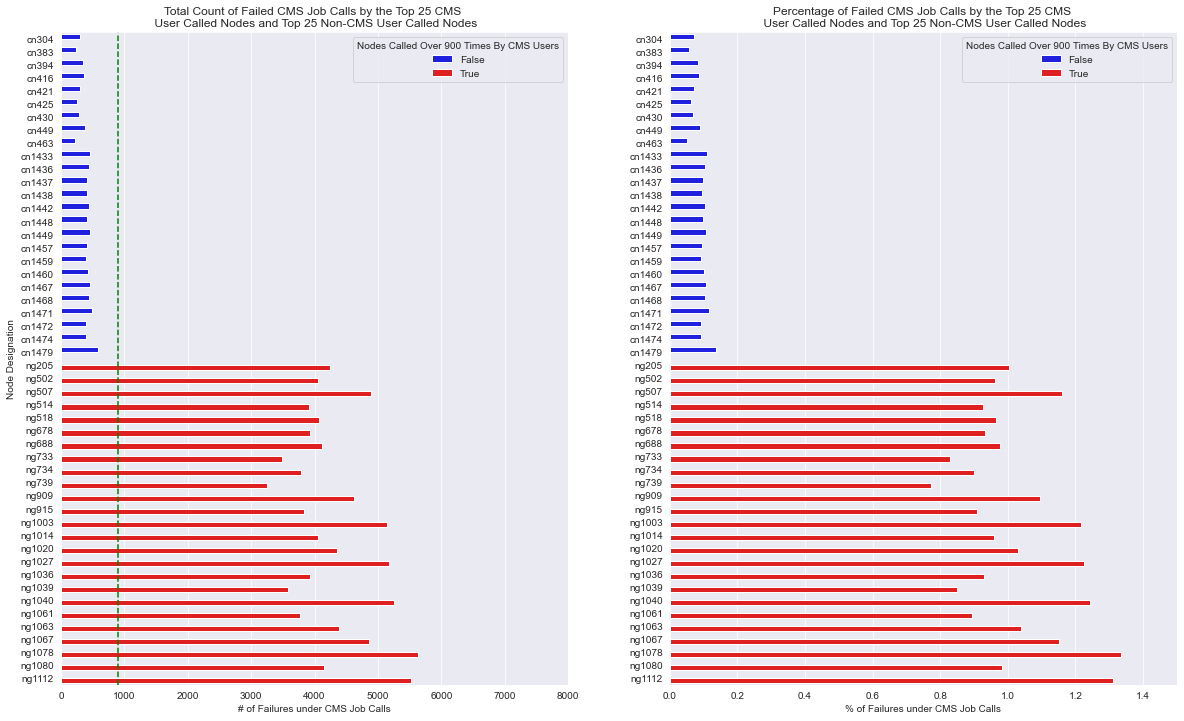

In [181]:
#Set the Seaborn style to darkgrid and the color palette to bright

sns.set_style('darkgrid')
sns.set_palette('bright')

#Creates a seaborn category plot of CMS called failures

fig, (ax0, ax1) = plt.subplots(1,2, figsize=(20,12))

g0 = sns.barplot(x = 'NODECOUNT_CMS', y = 'NODE', 
            data = nodes_25, ax = ax0,
            hue = 'TAG900', 
            palette = {False : 'blue', True : 'red'})

g1 = sns.barplot(x = 'PERC_CMS', y = 'NODE', 
            data = nodes_25, ax = ax1,
            hue = 'TAG900', 
            palette = {False : 'blue', True : 'red'})

#Inserts titles, sets the x and y axis labels, and edits the titles of the legends

ax0.set_title('Total Count of Failed CMS Job Calls by the Top 25 CMS \n User Called Nodes and Top 25 Non-CMS User Called Nodes')
ax0.set(xlabel = '# of Failures under CMS Job Calls', ylabel = 'Node Designation', xlim = (0,8000))
ax0.legend(title = 'Nodes Called Over 900 Times By CMS Users')
ax0.axvline(x = 900, color = 'green', label = '900 Job Calls', linestyle = '--')

ax1.set_title('Percentage of Failed CMS Job Calls by the Top 25 CMS \n User Called Nodes and Top 25 Non-CMS User Called Nodes')
ax1.set(xlabel = '% of Failures under CMS Job Calls', ylabel = '', xlim = (0,1.5))
ax1.legend(title = 'Nodes Called Over 900 Times By CMS Users')

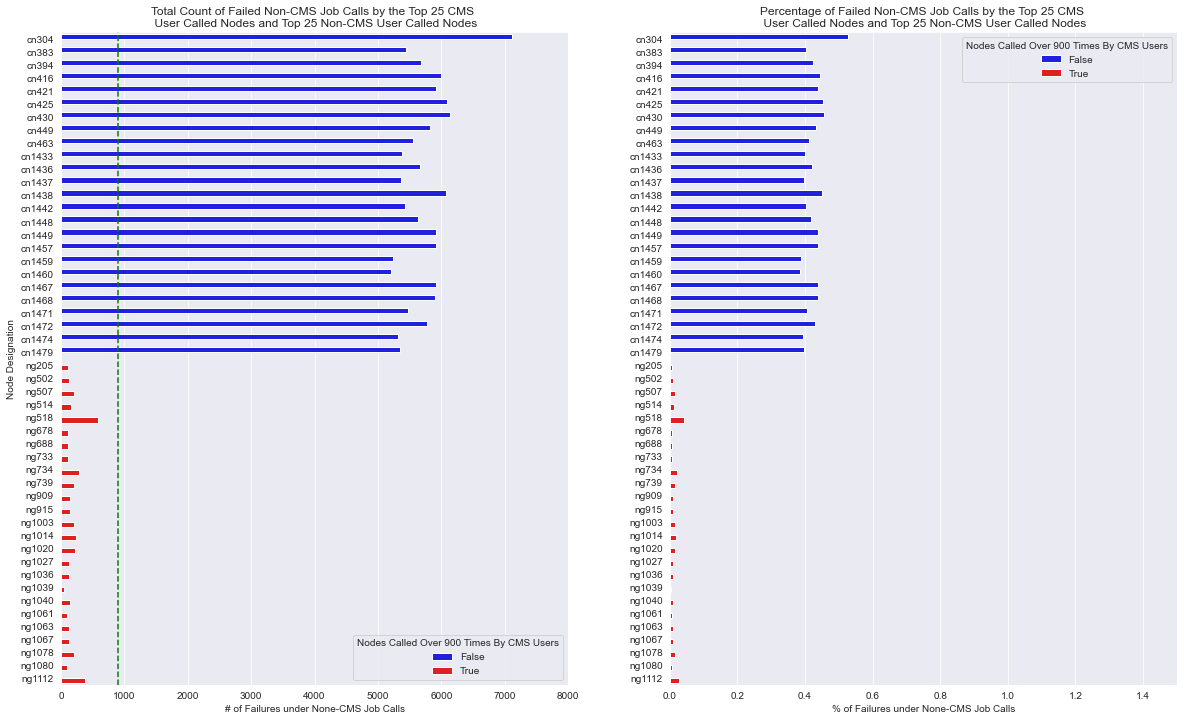

In [182]:
#Set the Seaborn style to darkgrid and the color palette to bright

sns.set_style('darkgrid')
sns.set_palette('bright')

#Creates a seaborn category plot of CMS called failures

fig, (ax0, ax1) = plt.subplots(1,2, figsize=(20,12))

g0 = sns.barplot(x = 'NODECOUNT_NCMS', y = 'NODE', 
            data = nodes_25, ax = ax0,
            hue = 'TAG900', 
            palette = {False : 'blue', True : 'red'})

g1 = sns.barplot(x = 'PERC_NCMS', y = 'NODE', 
            data = nodes_25, ax = ax1,
            hue = 'TAG900', 
            palette = {False : 'blue', True : 'red'})

#Inserts titles, sets the x and y axis labels, and edits the titles of the legends

ax0.set_title('Total Count of Failed Non-CMS Job Calls by the Top 25 CMS \n User Called Nodes and Top 25 Non-CMS User Called Nodes')
ax0.set(xlabel = '# of Failures under None-CMS Job Calls', ylabel = 'Node Designation', xlim = (0,8000))
ax0.legend(title = 'Nodes Called Over 900 Times By CMS Users')
ax0.axvline(x = 900, color = 'green', label = '900 Job Calls', linestyle = '--')

ax1.set_title('Percentage of Failed Non-CMS Job Calls by the Top 25 CMS \n User Called Nodes and Top 25 Non-CMS User Called Nodes')
ax1.set(xlabel = '% of Failures under None-CMS Job Calls', ylabel = '', xlim = (0,1.5))
ax1.legend(title = 'Nodes Called Over 900 Times By CMS Users')

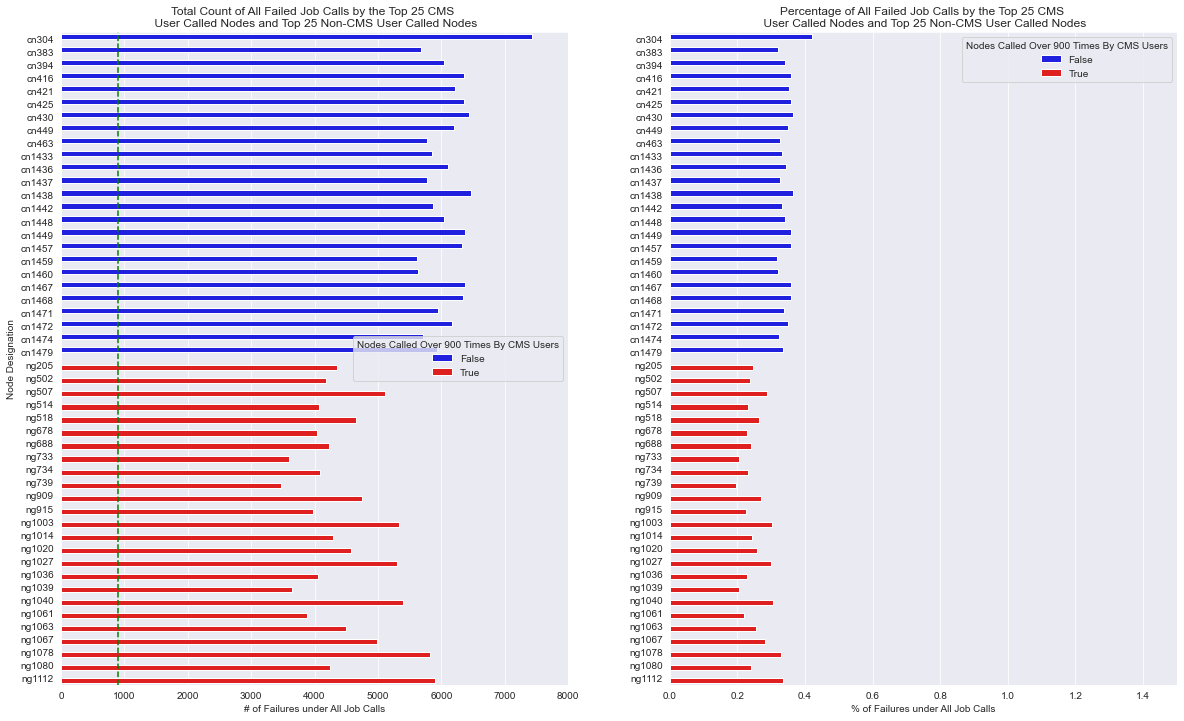

In [179]:
#Set the Seaborn style to darkgrid and the color palette to bright

sns.set_style('darkgrid')
sns.set_palette('bright')

#Creates a seaborn category plot of CMS called failures

fig, (ax0, ax1) = plt.subplots(1,2, figsize=(20,12))

g0 = sns.barplot(x = 'NODECOUNT_TOT', y = 'NODE', 
            data = nodes_25, ax = ax0,
            hue = 'TAG900', 
            palette = {False : 'blue', True : 'red'})

g1 = sns.barplot(x = 'PERC_TOT', y = 'NODE', 
            data = nodes_25, ax = ax1,
            hue = 'TAG900', 
            palette = {False : 'blue', True : 'red'})

#Inserts titles, sets the x and y axis labels, and edits the titles of the legends

ax0.set_title('Total Count of All Failed Job Calls by the Top 25 CMS \n User Called Nodes and Top 25 Non-CMS User Called Nodes')
ax0.set(xlabel = '# of Failures under All Job Calls', ylabel = 'Node Designation', xlim = (0,8000))
ax0.legend(title = 'Nodes Called Over 900 Times By CMS Users')
ax0.axvline(x = 900, color = 'green', label = '900 Job Calls', linestyle = '--')

ax1.set_title('Percentage of All Failed Job Calls by the Top 25 CMS \n User Called Nodes and Top 25 Non-CMS User Called Nodes')
ax1.set(xlabel = '% of Failures under All Job Calls', ylabel = '', xlim = (0,1.5))
ax1.legend(title = 'Nodes Called Over 900 Times By CMS Users')